## EDA and Data Cleaning

In [84]:
# Import libraries
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
import numpy as np
import gzip as gz
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from zipfile import ZipFile
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor, NearestNeighbors
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, plot_roc_curve, plot_confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.decomposition import PCA
from xgboost import XGBClassifier 
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline
from collections import Counter
from statsmodels.api import qqplot
from scipy import stats

In [85]:
# Load and explore dataset
nba = 'NBAInjuries.zip'
with ZipFile(nba, 'r') as zip:
    zip.extractall('nba_unzipped')
    
df = pd.read_csv('nba_unzipped/injuries_2010-2020.csv')
df

,Date,Team,Acquired,Relinquished,Notes
0,2010-10-03,Bulls,NaN,Carlos Boozer,fractured bone in right pinky finger (out indefinitely)
1,2010-10-06,Pistons,NaN,Jonas Jerebko,torn right Achilles tendon (out indefinitely)
2,2010-10-06,Pistons,NaN,Terrico White,broken fifth metatarsal in right foot (out indefinitely)
3,2010-10-08,Blazers,NaN,Jeff Ayres,torn ACL in right knee (out indefinitely)
4,2010-10-08,Nets,NaN,Troy Murphy,strained lower back (out indefinitely)
...,...,...,...,...,...
27100,2020-09-30,Lakers,Dion Waiters,NaN,activated from IL
27101,2020-10-02,Heat,NaN,Bam Adebayo,strained neck (DTD)
27102,2020-10-02,Heat,NaN,Goran Dragic,placed on IL with torn plantar fascia in left foot
27103,2020-10-02,Heat,Chris Silva,NaN,activated from IL


In [86]:
# Drop Acquired column, null values, and rename Relinquished to Name
df.drop(['Acquired'], axis=1, inplace=True)
df.dropna(inplace=True)
df.rename(columns={'Relinquished':'Name'}, inplace=True)
df.head()

,Date,Team,Name,Notes
0,2010-10-03,Bulls,Carlos Boozer,fractured bone in right pinky finger (out indefinitely)
1,2010-10-06,Pistons,Jonas Jerebko,torn right Achilles tendon (out indefinitely)
2,2010-10-06,Pistons,Terrico White,broken fifth metatarsal in right foot (out indefinitely)
3,2010-10-08,Blazers,Jeff Ayres,torn ACL in right knee (out indefinitely)
4,2010-10-08,Nets,Troy Murphy,strained lower back (out indefinitely)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17558 entries, 0 to 27102
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    17558 non-null  object
 1   Team    17558 non-null  object
 2   Name    17558 non-null  object
 3   Notes   17558 non-null  object
dtypes: object(4)
memory usage: 685.9+ KB


In [5]:
# Create series of Notes column
s1 = df.Notes

In [6]:
out_for_season = s1.str.contains('out for season', case=False)
out_for_season.value_counts()

False    16433
True      1125
Name: Notes, dtype: int64

In [7]:
# Binary label out_of_season as target
df = df.assign(out_for_season=pd.Series(out_for_season).values)
df = df*1

# Dataset of injuries that resulted in player being 'out for season'
ofs = df[(df['Notes'].str.contains('out for season', case=False))]
ofs.head()

,Date,Team,Name,Notes,out_for_season
8,2010-10-12,Bucks,Darington Hobson,surgery on left hip (out for season),1
17,2010-10-26,Blazers,Greg Oden,placed on IL with left knee injury (out for season),1
75,2010-10-27,Pistons,Jonas Jerebko,placed on IL recovering from surgery to repair torn right Achilles tendon (out for season),1
76,2010-10-27,Pistons,Terrico White,placed on IL recovering from surgery on right foot to repair broken fifth metatarsal (out for season),1
175,2010-11-04,Blazers,Elliot Williams,"dislocated patella in right knee (surgery, out for season)",1


In [8]:
# Split injury data by season
ofs_10 = ofs[(ofs['Date'] < '2011-07-01')]
ofs_11 = ofs[(ofs['Date'].between('2011-07-01','2012-07-01'))]
ofs_12 = ofs[(ofs['Date'].between('2012-07-01','2013-07-01'))]
ofs_13 = ofs[(ofs['Date'].between('2013-07-01','2014-07-01'))]
ofs_14 = ofs[(ofs['Date'].between('2014-07-01','2015-07-01'))]
ofs_15 = ofs[(ofs['Date'].between('2015-07-01','2016-07-01'))]
ofs_16 = ofs[(ofs['Date'].between('2016-07-01','2017-07-01'))]
ofs_17 = ofs[(ofs['Date'].between('2017-07-01','2018-07-01'))]
ofs_18 = ofs[(ofs['Date'].between('2018-07-01','2019-07-01'))]

Multiple entries for same player and injury are noted. The duplicates need to be removed.

In [9]:
# Function to drop duplicates
def DropDuplicates(dataset):
    return dataset.drop_duplicates(subset=['Name'], inplace=True)

# Make list of season datasets
list_ofs = [ofs_10, ofs_11, ofs_12, ofs_13, ofs_14, ofs_15,
            ofs_16, ofs_17, ofs_18]

# Apply function
[DropDuplicates(season) for season in list_ofs]

<ipython-input-9-b83b864be86c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return dataset.drop_duplicates(subset=['Name'], inplace=True)


[None, None, None, None, None, None, None, None, None]

Import NBA player stats

In [10]:
# Import player stats
p09 = pd.read_excel('player_stats/2009-2010.xlsx')
p10 = pd.read_excel('player_stats/2010-2011.xlsx')
p11 = pd.read_excel('player_stats/2011-2012.xlsx')
p12 = pd.read_excel('player_stats/2012-2013.xlsx')
p13 = pd.read_excel('player_stats/2013-2014.xlsx')
p14 = pd.read_excel('player_stats/2014-2015.xlsx')
p15 = pd.read_excel('player_stats/2015-2016.xlsx')
p16 = pd.read_excel('player_stats/2016-2017.xlsx')
p17 = pd.read_excel('player_stats/2017-2018.xlsx')

In [11]:
# Merge stats dataset with injury dataset
s09 = pd.merge(p09,ofs_10, how='left', on='Name')
s10 = pd.merge(p10,ofs_11, how='left', on='Name')
s11 = pd.merge(p11,ofs_12, how='left', on='Name')
s12 = pd.merge(p12,ofs_13, how='left', on='Name')
s13 = pd.merge(p13,ofs_14, how='left', on='Name')
s14 = pd.merge(p14,ofs_15, how='left', on='Name')
s15 = pd.merge(p15,ofs_16, how='left', on='Name')
s16 = pd.merge(p16,ofs_17, how='left', on='Name')
s17 = pd.merge(p17,ofs_18, how='left', on='Name')

In [12]:
# Concatenate season datasets into main dataset
df_con = pd.concat([s09,s10,s11,s12,s13,s14,s15,s16,s17], axis=0)
df_con.head()

,Name,TEAM,AGE,HEIGHT,WEIGHT,COLLEGE,COUNTRY,DRAFT YEAR,DRAFT ROUND,DRAFT NUMBER,GP,NETRTG,TS%,W,L,MPG,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,MIN,USG%,%FGM,%FGA,%3PM,%3PA,%FTM,%FTA,%OREB,%DREB,%REB,%AST,%TOV,%STL,%BLK,%BLKA,%PF,%PFD,%PTS,Date,Team,Notes,out_for_season
0,Aaron Brooks,HOU,25,6-1,161,Oregon,USA,2007,1,26,82,0.2,0.549,42,40,35.6,19.6,7.0,16.2,43.2,2.5,6.4,39.8,3.0,3.6,82.2,0.7,2.0,2.6,5.3,2.8,0.8,0.2,2.4,30.9,6,0,-0.3,2919,25.4,25.1,26.2,41.5,37.8,22.5,21.1,8.1,8.8,8.6,32.7,27.0,16.2,6.2,21.3,16.3,19.7,26.0,NaN,NaN,NaN,NaN
1,Aaron Gray,NOH,25,7-1,270,Pittsburgh,USA,2007,2,49,32,-3.1,0.551,11,21,9.7,3.3,1.3,2.6,51.2,0.0,0.0,0.0,0.6,0.9,71.4,1.4,1.9,3.3,0.7,0.6,0.3,0.3,1.7,9.6,0,0,-0.4,311,16.0,17.2,15.4,0.0,0.0,21.5,23.1,52.3,30.8,37.3,16.5,18.0,18.0,35.5,25.0,37.5,18.5,16.9,NaN,NaN,NaN,NaN
2,Acie Law,CHI,25,6-3,202,Texas A&M,USA,2007,1,11,26,5.3,0.585,11,15,9.0,4.3,1.3,2.9,46.7,0.2,0.6,31.3,1.5,1.9,77.6,0.1,0.5,0.7,1.0,0.7,0.4,0.0,0.6,7.4,0,0,0.8,234,21.4,18.6,19.4,14.7,18.4,29.9,30.4,6.1,10.3,9.2,26.0,29.8,24.4,4.2,39.4,14.0,27.8,21.0,2011-03-29,Warriors,placed on IL with right wrist injury (out for season),1.0
3,Adam Morrison,LAL,25,6-8,205,Gonzaga,USA,2006,1,3,31,-8.3,0.418,23,8,7.8,2.4,1.0,2.7,37.6,0.2,0.7,23.8,0.2,0.3,62.5,0.3,0.7,1.0,0.6,0.3,0.1,0.1,0.5,4.7,0,0,-1.2,241,17.8,17.7,20.1,13.9,21.2,6.8,7.7,16.4,13.6,14.3,16.8,13.9,10.0,8.0,30.0,20.2,5.8,15.7,NaN,NaN,NaN,NaN
4,AJ Price,IND,23,6-2,181,Connecticut,USA,2009,2,52,56,3.9,0.530,23,33,15.5,7.3,2.6,6.3,41.0,1.1,3.1,34.5,1.1,1.3,80.0,0.2,1.4,1.6,1.9,1.1,0.6,0.1,0.9,13.0,0,0,0.9,865,21.9,21.3,23.2,32.4,34.3,19.2,18.0,7.4,13.4,12.1,27.4,21.5,25.5,3.2,23.8,13.6,20.2,22.0,NaN,NaN,NaN,NaN


Let the data cleaning begin

In [13]:
# Function to convert ft-in height into inches
def parse_ht(height):
    ht_ = height.split("-")
    ft_ = int(ht_[0])
    in_ = int(ht_[1])
    return (12*ft_) + in_
df_con["HEIGHT"] = df_con["HEIGHT"].apply(lambda x:parse_ht(x))

In [14]:
# Binary bin Country['USA'] = 1, other = 0
df_con.COUNTRY.replace(to_replace='USA', value=1, inplace=True) 
df_con.loc[df_con['COUNTRY'] != 1, 'COUNTRY'] = 0
df_con['COUNTRY'] = df_con['COUNTRY'].astype(int)
df_con.COUNTRY.value_counts()

1    3456
0     861
Name: COUNTRY, dtype: int64

In [15]:
# Binary bin College = 1 , no College = 0
df_con.COLLEGE.replace(to_replace='None', value=0, inplace=True)
df_con.loc[df_con['COLLEGE'] != 0, 'COLLEGE'] = 1
df_con['COLLEGE'] = df_con['COLLEGE'].astype(int)
df_con.COLLEGE.value_counts()

1    3572
0     745
Name: COLLEGE, dtype: int64

In [16]:
# Replace Undrafted and Nan with 0
df_con.replace(to_replace='Undrafted', value=0, inplace=True)
df_con['out_for_season'].fillna(0, inplace=True)

In [17]:
# DRAFT YEAR dropped because because undrafted player data was not recorded
df_con.drop('DRAFT YEAR', axis=1, inplace=True)

In [18]:
# Function to convert strings to numeric
def MakeNumeric(Column):
    df_con[Column] = df_con[Column].astype(int)
    return df_con

# Make list of columns to be convert to numeric values
make_columns_numeric = ['COUNTRY', 'COLLEGE', 'DRAFT ROUND', 'DRAFT NUMBER', 'out_for_season']

# Apply function
[MakeNumeric(column) for column in make_columns_numeric]

[              Name TEAM  AGE  HEIGHT  WEIGHT  COLLEGE  COUNTRY  DRAFT ROUND  \
 0     Aaron Brooks  HOU   25      73     161        1        1            1   
 1       Aaron Gray  NOH   25      85     270        1        1            2   
 2         Acie Law  CHI   25      75     202        1        1            1   
 3    Adam Morrison  LAL   25      80     205        1        1            1   
 4         AJ Price  IND   23      74     181        1        1            2   
 ..             ...  ...  ...     ...     ...      ...      ...          ...   
 535   Zach Collins  POR   20      85     230        1        1            1   
 536    Zach LaVine  CHI   23      77     185        1        1            1   
 537  Zach Randolph  SAC   36      81     250        1        1            1   
 538  Zaza Pachulia  GSW   34      83     270        0        0            2   
 539        Zhou Qi  HOU   22      85     210        0        0            2   
 
      DRAFT NUMBER  GP  NETRTG    TS% 

Now let's do a heatmap to check for multicollinearity

In [19]:
# # Heatmap to display data correlations
# CORR = df_con.corr().abs()
# fig, ax=plt.subplots(figsize=(40,60))
# sns.heatmap(CORR, cmap='Reds', annot=True);

Using a pearson correlation coefficient cutoff of 0.85, here we see that (draft round, draft number), (true shooting percentage, field goal percentage), (minutes per game, minutes played), (minutes per game, points per game), (minutes per game, field goals made), (minutes per game, field goals attempted), (3pt made, 3pt attempted), (free throws made, points per game), (free throws made, field goals made), (free throws made, free throws attempted), (free throws attempted, free throws attempted), (free throws attempted, points per game), (offensive rebounds, rebounds), (defensive rebounds, rebounds), (fantasy points, minutes per game), (fantasy points, points per game), (fantasy points, field goals made), (fantasy points, field goals attempted), (fantasy points, free throws made), (fantasy points, free throws attempted), (fantasy points, turnovers), (usage percentage, percent of team’s field goals attempted), (percent of team’s 3pt made, percent of team’s 3pt attempted), (percent of team’s free throws made, percent of team’s free throws attempted), (percent of team’s defensive rebounds, percent of team’s rebounds), (usage percentage, percent of team’s points scored), (percent of team’s field goals made, percent of team’s points scored), (percent of team’s personal fouls drawn, percent of team’s free throws attempted) demonstrate high multicollinearity

In [20]:
# Dummify Teams
df_con = pd.get_dummies(df_con, columns=['TEAM'], drop_first=True)
df_con

,Name,AGE,HEIGHT,WEIGHT,COLLEGE,COUNTRY,DRAFT ROUND,DRAFT NUMBER,GP,NETRTG,TS%,W,L,MPG,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,MIN,USG%,%FGM,%FGA,%3PM,%3PA,%FTM,%FTA,%OREB,%DREB,%REB,%AST,%TOV,%STL,%BLK,%BLKA,%PF,%PFD,%PTS,Date,Team,Notes,out_for_season,TEAM_BKN,TEAM_BOS,TEAM_CHA,TEAM_CHI,TEAM_CLE,TEAM_DAL,TEAM_DEN,TEAM_DET,TEAM_GSW,TEAM_HOU,TEAM_IND,TEAM_LAC,TEAM_LAL,TEAM_MEM,TEAM_MIA,TEAM_MIL,TEAM_MIN,TEAM_NJN,TEAM_NOH,TEAM_NOP,TEAM_NYK,TEAM_OKC,TEAM_ORL,TEAM_PHI,TEAM_PHX,TEAM_POR,TEAM_SAC,TEAM_SAS,TEAM_TOR,TEAM_UTA,TEAM_WAS
0,Aaron Brooks,25,73,161,1,1,1,26,82,0.2,0.549,42,40,35.6,19.6,7.0,16.2,43.2,2.5,6.4,39.8,3.0,3.6,82.2,0.7,2.0,2.6,5.3,2.8,0.8,0.2,2.4,30.9,6,0,-0.3,2919,25.4,25.1,26.2,41.5,37.8,22.5,21.1,8.1,8.8,8.6,32.7,27.0,16.2,6.2,21.3,16.3,19.7,26.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Aaron Gray,25,85,270,1,1,2,49,32,-3.1,0.551,11,21,9.7,3.3,1.3,2.6,51.2,0.0,0.0,0.0,0.6,0.9,71.4,1.4,1.9,3.3,0.7,0.6,0.3,0.3,1.7,9.6,0,0,-0.4,311,16.0,17.2,15.4,0.0,0.0,21.5,23.1,52.3,30.8,37.3,16.5,18.0,18.0,35.5,25.0,37.5,18.5,16.9,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,Acie Law,25,75,202,1,1,1,11,26,5.3,0.585,11,15,9.0,4.3,1.3,2.9,46.7,0.2,0.6,31.3,1.5,1.9,77.6,0.1,0.5,0.7,1.0,0.7,0.4,0.0,0.6,7.4,0,0,0.8,234,21.4,18.6,19.4,14.7,18.4,29.9,30.4,6.1,10.3,9.2,26.0,29.8,24.4,4.2,39.4,14.0,27.8,21.0,2011-03-29,Warriors,placed on IL with right wrist injury (out for season),1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Adam Morrison,25,80,205,1,1,1,3,31,-8.3,0.418,23,8,7.8,2.4,1.0,2.7,37.6,0.2,0.7,23.8,0.2,0.3,62.5,0.3,0.7,1.0,0.6,0.3,0.1,0.1,0.5,4.7,0,0,-1.2,241,17.8,17.7,20.1,13.9,21.2,6.8,7.7,16.4,13.6,14.3,16.8,13.9,10.0,8.0,30.0,20.2,5.8,15.7,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,AJ Price,23,74,181,1,1,2,52,56,3.9,0.530,23,33,15.5,7.3,2.6,6.3,41.0,1.1,3.1,34.5,1.1,1.3,80.0,0.2,1.4,1.6,1.9,1.1,0.6,0.1,0.9,13.0,0,0,0.9,865,21.9,21.3,23.2,32.4,34.3,19.2,18.0,7.4,13.4,12.1,27.4,21.5,25.5,3.2,23.8,13.6,20.2,22.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,Zach Collins,20,85,230,1,1,1,10,66,1.3,0.475,41,25,15.8,4.4,1.7,4.4,39.8,0.5,1.7,31.0,0.4,0.6,64.3,0.7,2.7,3.3,0.8,0.9,0.3,0.5,2.0,10.9,0,0,0.2,1045,15.3,13.5,15.7,14.6,18.4,8.8,10.6,20.8,22.8,22.4,12.7,19.3,14.7,34.8,16.2,28.2,12.6,12.9,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
536,Zach LaVine,23,77,185,1,1,1,13,24,-12.1,0.499,9,15,27.3,16.7,5.7,14.8,38.3,1.8,5.1,34.1,3.6,4.5,81.3,0.4,3.5,3.9,3.0,1.8,1.0,0.2,2.3,27.6,0,0,-7.2,656,29.0,26.1,29.5,30.4,30.5,39.2,37.5,7.5,18.4,16.2,24.7,25.1,23.3,8.9,43.5,20.2,28.8,28.6,2019-03-20,Bulls,bruised right thigh (out for season),1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
537,Zach Randolph,36,81,250,1,1,1,19,59,-12.2,0.529,18,41,25.6,14.5,6.1,12.9,47.3,0.9,2.5,34.7,1.4,1.8,78.5,1.6,5.1,6.7,2.2,2.0,0.7,0.2,2.0,26.5,8,0,-6.0,1508,27.0,29.3,28.2,18.5,20.3,23.2,21.4,32.6,30.4,30.9,19.1,26.0,18.1,9.5,26.7,19.6,26.1,27.6,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
538,Zaza Pachulia,34,83,270,0,0,2,42,69,9.4,0.612,47,22,14.1,5.4,2.2,3.8,56.4,0.0,0.0,0.0,1.1,1.3,80.6,1.3,3.4,4.7,1.6,1.0,0.6,0.2,1.8,14.7,2,0,2.8,972,16.5,16.1,14.8,0.0,0.2,26.8,28.0,48.4,32.4,35.6,16.3,22.6,24.4,15.0,39.8,36.6,27.5,15.5,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
df_con.describe()

,AGE,HEIGHT,WEIGHT,COLLEGE,COUNTRY,DRAFT ROUND,DRAFT NUMBER,GP,NETRTG,TS%,W,L,MPG,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,MIN,USG%,%FGM,%FGA,%3PM,%3PA,%FTM,%FTA,%OREB,%DREB,%REB,%AST,%TOV,%STL,%BLK,%BLKA,%PF,%PFD,%PTS,out_for_season,TEAM_BKN,TEAM_BOS,TEAM_CHA,TEAM_CHI,TEAM_CLE,TEAM_DAL,TEAM_DEN,TEAM_DET,TEAM_GSW,TEAM_HOU,TEAM_IND,TEAM_LAC,TEAM_LAL,TEAM_MEM,TEAM_MIA,TEAM_MIL,TEAM_MIN,TEAM_NJN,TEAM_NOH,TEAM_NOP,TEAM_NYK,TEAM_OKC,TEAM_ORL,TEAM_PHI,TEAM_PHX,TEAM_POR,TEAM_SAC,TEAM_SAS,TEAM_TOR,TEAM_UTA,TEAM_WAS
count,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.00000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000
mean,26.962474,79.158907,221.557331,0.827426,0.800556,1.056521,17.999305,52.444753,-2.139958,0.515802,26.248552,26.196201,20.206185,8.198193,3.071253,6.844174,43.816817,0.641209,1.832708,25.254969,1.418346,1.885685,70.110100,0.901158,2.645217,3.544035,1.800556,1.150961,0.635441,0.405513,1.746583,17.117443,4.237433,0.118601,-0.345587,1213.017836,18.136808,18.260459,18.699884,17.300695,18.111026,17.341788,17.885013,20.508548,19.694811,19.985268,18.098494,18.254413,19.262868,19.996965,19.168334,22.005606,18.362613,18.105791,0.121149,0.023859,0.033356,0.033588,0.031735,0.034978,0.034746,0.032198,0.031040,0.032198,0.033125,0.03243,0.033356,0.033820,0.036368,0.033125,0.034283,0.032662,0.012509,0.015288,0.020848,0.033820,0.033356,0.031040,0.034051,0.032198,0.031503,0.032198,0.033588,0.033125,0.032662,0.034051
std,4.262036,3.553347,26.616005,0.377922,0.399629,0.638981,16.163703,24.696246,11.887091,0.097981,15.968330,14.620618,9.457667,5.742736,2.096509,4.436207,9.832629,0.695200,1.816217,16.981427,1.338567,1.664693,19.822599,0.809434,1.769777,2.446181,1.778900,0.778435,0.428340,0.438700,0.751397,10.486305,9.174975,1.071935,2.927873,857.427097,5.197265,6.358304,5.841734,15.369848,14.433505,10.430400,10.074568,15.437418,8.832157,9.685951,12.663147,8.054364,9.776307,17.953947,11.251355,8.907587,8.941240,6.191234,0.326338,0.152628,0.179587,0.180187,0.175314,0.183745,0.183158,0.176547,0.173446,0.176547,0.178983,0.17716,0.179587,0.180786,0.187225,0.178983,0.181976,0.177770,0.111153,0.122712,0.142891,0.180786,0.179587,0.173446,0.181382,0.176547,0.174694,0.176547,0.180187,0.178983,0.177770,0.181382
min,19.000000,65.000000,133.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-150.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.800000,0.000000,0.000000,-19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24

## Modeling

Assign X and y values, train_test_split, scale data

In [22]:
# Assign X and y. 
y = df_con.out_for_season
X = df_con.drop(['Name', 'Date', 'Team', 'Notes', 'out_for_season'], axis=1) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=22) 

# Scale data
scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train)
X_test_scaled = scale.transform(X_test)

In [23]:
# Assess target balance
y.value_counts()

0    3794
1     523
Name: out_for_season, dtype: int64

Given the target variable imbalance will elect to SMOTE which will allow me to use accuracy as primary metric along with ROC AUC as a secondary metric

### SMOTE

In [24]:
# SMOTE to oversample minority class
sm = SMOTE(random_state=22)
X_train_smote, y_train_smote = sm.fit_resample(X_train_scaled, y_train)

counter = Counter(y_train)
smote_counter = Counter(y_train_smote)
print(counter)
print(smote_counter)

Counter({0: 2851, 1: 386})
Counter({0: 2851, 1: 2851})


We now have evenly matched target variables

### Model 0: DummyClassifier Baseline Model

Train:               precision    recall  f1-score   support

           0       0.50      1.00      0.67      2851
           1       0.00      0.00      0.00      2851

    accuracy                           0.50      5702
   macro avg       0.25      0.50      0.33      5702
weighted avg       0.25      0.50      0.33      5702

Test:               precision    recall  f1-score   support

           0       0.87      1.00      0.93       943
           1       0.00      0.00      0.00       137

    accuracy                           0.87      1080
   macro avg       0.44      0.50      0.47      1080
weighted avg       0.76      0.87      0.81      1080



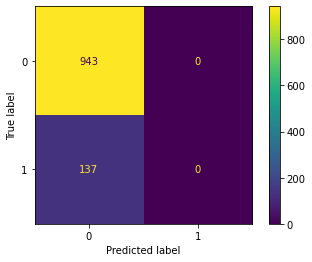

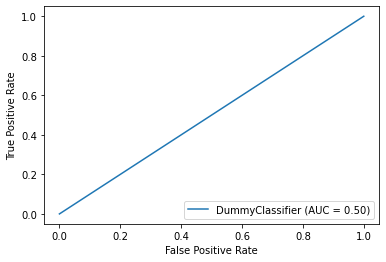

In [25]:
# Instantiate, fit, and run dummy model
dc = DummyClassifier(strategy="most_frequent", random_state=22)
dc.fit(X_train_smote, y_train_smote)
y_hat_train = dc.predict(X_train_smote)
y_hat_test = dc.predict(X_test_scaled)
print(f'Train: {classification_report(y_train_smote, y_hat_train, zero_division=0)}')
print(f'Test: {classification_report(y_test, y_hat_test, zero_division=0)}')

# Plot confusion matrix and ROC AUC for dummy model
plot_confusion_matrix(dc, X_test_scaled, y_test)
plot_roc_curve(dc, X_test_scaled, y_test);

Now that we have a baseline model, let us build a pipeline to streamline the rest of the modeling process

### Pipeline Construction

In [26]:
# Function with classifier input and pipeline output
def pipe_maker(classifier):
    pipe = imbPipeline([('scl', StandardScaler()), ('smt', SMOTE(random_state=22)), 
                        ('clf', classifier(random_state=22))])
    return pipe

In [27]:
# Function with Pipeline & Parameters input and gridsearch with optimum parameters output
def gridsearch_maker(pipeline, params):
    return GridSearchCV(estimator=pipeline,
                        param_grid=params,
                        scoring='accuracy',
                        cv=10,
                        n_jobs=-1)

In [28]:
# Function with pipline/gridsearch input and hyperparameters out for optimized accuracy
def best_acc(gridsearch):

    # Instantiate best_acc object
    best_acc = 0.0
    
    # Fit gridsearch to regularized data set
    gridsearch.fit(X_train, y_train)
    
    # Print best parameters
    print('Best paramaters are: %s' % gridsearch.best_params_)
    
    # Print best train accuracy_score
    print('Best training accuracy_score: %.3f' % gridsearch.best_score_)
    
    # Prediction on scaled test data
    y_hat_test = gridsearch.predict(X_test)
    
    # Print test data accuracy_score with best params
    print('Test accuracy_score with best parameters: %.3f ' % accuracy_score(y_test, y_hat_test))
    
    # Print confusion matrix and classification report
    print('Test: ', classification_report(y_test, y_hat_test))
    
    # Plot confusion matrix and ROC AUC
    plot_confusion_matrix(gridsearch, X_test, y_test,cmap="plasma")
    plot_roc_curve(gridsearch, X_test, y_test);

Model away...

### Model 1: Logistic Regression Model

Best paramaters are: {'clf__dual': True, 'clf__max_iter': 10000, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best training accuracy_score: 0.609
Test accuracy_score with best parameters: 0.629 
Test:                precision    recall  f1-score   support

           0       0.92      0.63      0.75       943
           1       0.19      0.61      0.29       137

    accuracy                           0.63      1080
   macro avg       0.55      0.62      0.52      1080
weighted avg       0.83      0.63      0.69      1080



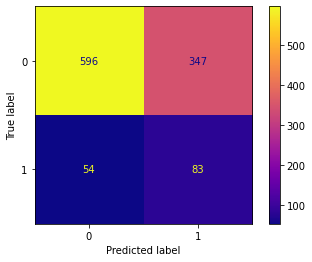

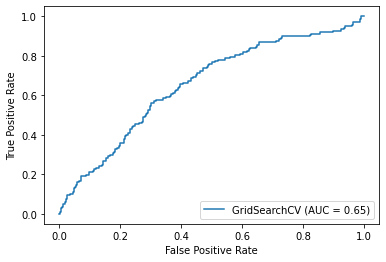

In [44]:
# pipe_dt = pipe_maker(LogisticRegression)
# grid_params_dt = [{'clf__penalty': ['l1', 'l2', 'elasticnet'],
#                   'clf__solver': ['liblinear', 'saga'],
#                   'clf__dual': [True, False],
#                   'clf__max_iter': [10000,100000]}]
# gs_dt = gridsearch_maker(pipe_dt, grid_params_dt)
# best_acc(gs_dt)

Now we will quantify the risk factors by calling the coefficients on the optimized parameter model

In [30]:
# Instantiate, fit, and run model with best parameters
# Print odds ratios and identify top 5 risk factors
lr = LogisticRegression(max_iter=10000, dual=True, penalty='l2', solver='liblinear', random_state=22)
lr.fit(X_train_smote, y_train_smote)
print(np.exp(lr.coef_))
COEF = np.exp(lr.coef_[0])
odds = pd.DataFrame(COEF, X.columns, 
        columns=['odds']).sort_values(by='odds', ascending=False)
odds.head(10)

[[0.84756339 1.38805025 0.93795531 0.85209516 1.01765816 0.97342736
  0.93193359 1.10986101 1.26198027 0.87873208 1.17440875 1.00095322
  2.07067906 3.02323277 0.8430407  0.68550695 1.24323869 0.89580759
  1.15001435 1.19896943 0.67745745 0.9764114  0.94796324 0.52931602
  0.42314434 3.89923905 0.81791905 0.92555672 0.62921497 0.83017946
  1.18227976 1.69276616 0.84999101 0.920372   0.84118773 0.74843489
  0.4957615  0.82444993 1.0229857  0.96113834 0.93035771 1.01975263
  1.10287828 1.00806168 0.71658808 1.41219836 1.2787111  1.20717289
  1.35355641 1.06891301 1.21590808 0.74856606 1.02114013 1.35618875
  0.85871168 0.70018938 0.76183239 0.80550354 0.64466045 0.79389809
  0.79818509 0.71517487 0.67908415 0.81362473 0.68810347 0.65566875
  0.73252903 0.71682528 0.69956214 0.7988444  0.85251577 0.85489933
  0.80486619 0.85441336 0.78405337 0.64769073 0.7722623  0.68913592
  0.7742427  0.69676446 0.80335675 0.67243134 0.6742078  0.82231349
  0.69433678]]


,odds
REB,3.899239
PTS,3.023233
MPG,2.070679
FP,1.692766
%REB,1.412198
HEIGHT,1.388050
%PTS,1.356189
%STL,1.353556
%AST,1.278711
NETRTG,1.261980


Here we see the 5 most impactful prior season risk factors for sustaining season-ending injuries are:
1. Rebounds per Game
2. Points per Game
3. Minutes per Game
4. Fantasy Points
5. Percent of Team's Total Rebounds

### Model 1.2: Top10 Feature Logistic Regression Model

Now that we have identified the top risk factors we will reduce the complexity of our data by using just the top 10 features

In [31]:
top10 = list(odds.index.values[:10])
top10

['REB', 'PTS', 'MPG', 'FP', '%REB', 'HEIGHT', '%PTS', '%STL', '%AST', 'NETRTG']

In [32]:
# Reassign X and y. 
y = df_con.out_for_season
X = df_con[top10] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=22) 

# Scale data
scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train)
X_test_scaled = scale.transform(X_test)

# ReSMOTE to oversample minority class
sm = SMOTE(random_state=22)
X_train_smote, y_train_smote = sm.fit_resample(X_train_scaled, y_train)

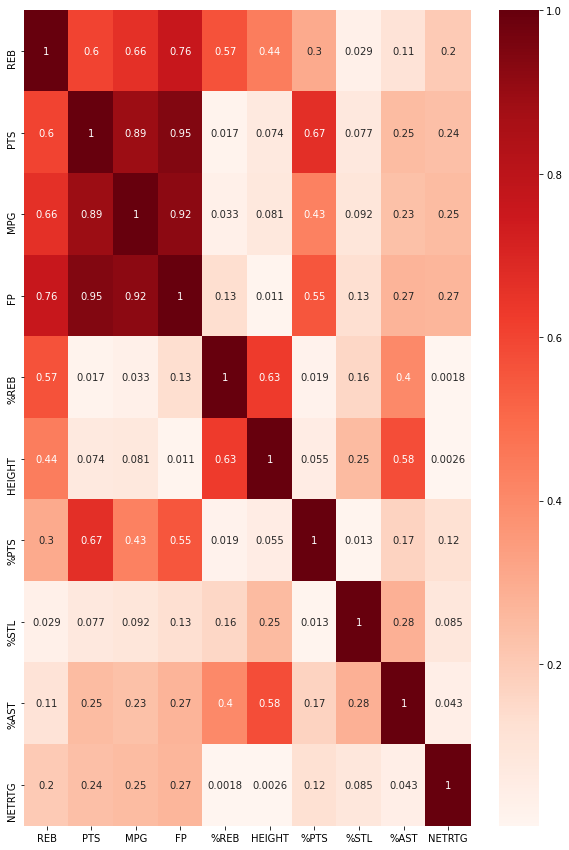

In [33]:
# Heatmap to display data correlations
CORR = X.corr().abs()
fig, ax=plt.subplots(figsize=(10,15))
sns.heatmap(CORR, cmap='Reds', annot=True);

Best paramaters are: {'clf__dual': True, 'clf__max_iter': 1000, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best training accuracy_score: 0.609
Test accuracy_score with best parameters: 0.629 
Test:                precision    recall  f1-score   support

           0       0.92      0.63      0.75       943
           1       0.19      0.61      0.29       137

    accuracy                           0.63      1080
   macro avg       0.55      0.62      0.52      1080
weighted avg       0.83      0.63      0.69      1080



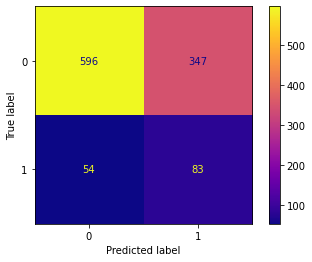

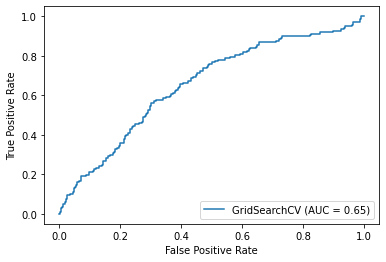

In [34]:
pipe_dt = pipe_maker(LogisticRegression)
grid_params_dt = [{'clf__penalty': ['l1', 'l2', 'elasticnet'],
                  'clf__solver': ['liblinear', 'saga'],
                  'clf__dual': [True, False],
                  'clf__max_iter': [1000,10000]}]
gs_dt = gridsearch_maker(pipe_dt, grid_params_dt)
best_acc(gs_dt)

Train:               precision    recall  f1-score   support

           0       0.63      0.61      0.62      2851
           1       0.62      0.65      0.64      2851

    accuracy                           0.63      5702
   macro avg       0.63      0.63      0.63      5702
weighted avg       0.63      0.63      0.63      5702

Test:               precision    recall  f1-score   support

           0       0.92      0.63      0.75       943
           1       0.19      0.61      0.29       137

    accuracy                           0.63      1080
   macro avg       0.55      0.62      0.52      1080
weighted avg       0.83      0.63      0.69      1080



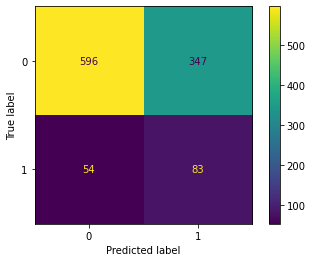

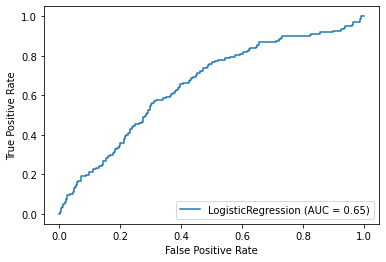

In [35]:
# Instantiate, fit, and run model
lr = LogisticRegression(max_iter = 1000, random_state=22)
lr.fit(X_train_smote, y_train_smote)
y_hat_train = lr.predict(X_train_smote)
y_hat_test = lr.predict(X_test_scaled)
print(f'Train: {classification_report(y_train_smote, y_hat_train)}')
print(f'Test: {classification_report(y_test, y_hat_test)}')

# Plot confusion matrix and ROC AUC
plot_confusion_matrix(lr, X_test_scaled, y_test)
plot_roc_curve(lr, X_test_scaled, y_test);

### Model 2: Random Forest Model

Best paramaters are: {'clf__class_weight': 'balanced', 'clf__criterion': 'gini', 'clf__max_depth': 50}
Best training accuracy_score: 0.819
Test accuracy_score with best parameters: 0.819 
Test:                precision    recall  f1-score   support

           0       0.88      0.91      0.90       943
           1       0.22      0.18      0.20       137

    accuracy                           0.82      1080
   macro avg       0.55      0.54      0.55      1080
weighted avg       0.80      0.82      0.81      1080



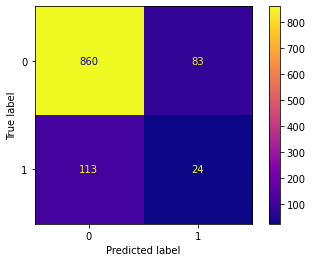

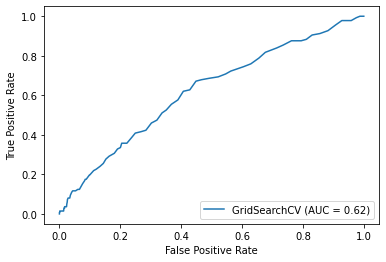

In [36]:
pipe_dt = pipe_maker(RandomForestClassifier)
grid_params_dt = [{'clf__criterion': ['gini', 'entropy'],
                  'clf__max_depth': [40,50,60],
                  'clf__class_weight': ['balanced', 'balanced_subsample']}]
gs_dt = gridsearch_maker(pipe_dt, grid_params_dt)
best_acc(gs_dt)

Train:               precision    recall  f1-score   support

           0       0.61      1.00      0.75      2851
           1       1.00      0.35      0.52      2851

    accuracy                           0.67      5702
   macro avg       0.80      0.67      0.64      5702
weighted avg       0.80      0.67      0.64      5702

Test:               precision    recall  f1-score   support

           0       0.87      1.00      0.93       943
           1       0.00      0.00      0.00       137

    accuracy                           0.87      1080
   macro avg       0.44      0.50      0.47      1080
weighted avg       0.76      0.87      0.81      1080



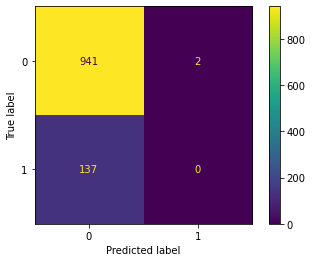

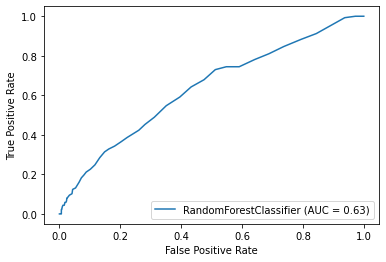

In [40]:
# Instantiate, fit, and run model
rfc = RandomForestClassifier(random_state=22)
rfc.fit(X_train_scaled, y_train)
y_hat_train = rfc.predict(X_train_smote)
y_hat_test = rfc.predict(X_test_scaled)
print(f'Train: {classification_report(y_train_smote, y_hat_train)}')
print(f'Test: {classification_report(y_test, y_hat_test)}')

# Plot confusion matrix and ROC AUC
plot_confusion_matrix(rfc, X_test_scaled, y_test)
plot_roc_curve(rfc, X_test_scaled, y_test);

### Model 3: XGBoost Model

Best paramaters are: {'clf__booster': 'gbtree', 'clf__eta': 0.25, 'clf__max_depth': 8}
Best training accuracy_score: 0.836
Test accuracy_score with best parameters: 0.832 
Test:                precision    recall  f1-score   support

           0       0.88      0.93      0.91       943
           1       0.24      0.15      0.18       137

    accuracy                           0.83      1080
   macro avg       0.56      0.54      0.54      1080
weighted avg       0.80      0.83      0.81      1080



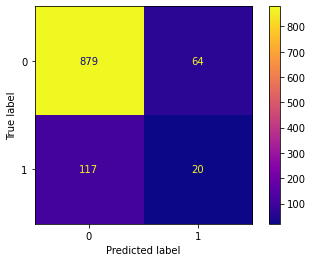

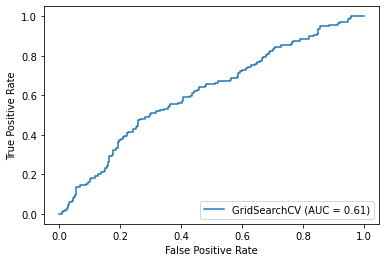

In [49]:
pipe_dt = pipe_maker(XGBClassifier)
grid_params_dt = [{'clf__booster': ['gbtree', 'gblinear', 'gbdart'],
                  'clf__eta': [.2,.25,.3],
                  'clf__max_depth': [7,8,9]}]
gs_dt = gridsearch_maker(pipe_dt, grid_params_dt)
best_acc(gs_dt)

Train:               precision    recall  f1-score   support

           0       0.64      1.00      0.78      2851
           1       1.00      0.43      0.60      2851

    accuracy                           0.71      5702
   macro avg       0.82      0.71      0.69      5702
weighted avg       0.82      0.71      0.69      5702

Test:               precision    recall  f1-score   support

           0       0.87      0.98      0.92       943
           1       0.19      0.04      0.06       137

    accuracy                           0.86      1080
   macro avg       0.53      0.51      0.49      1080
weighted avg       0.79      0.86      0.81      1080



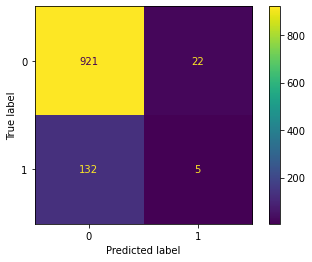

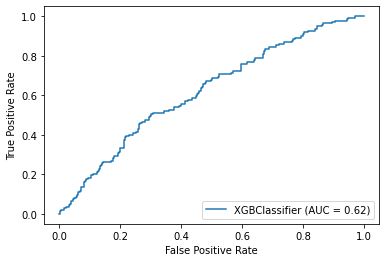

In [42]:
# Instantiate, fit, and run model
xgb = XGBClassifier(random_state=22)
xgb.fit(X_train_scaled, y_train)
y_hat_train = xgb.predict(X_train_smote)
y_hat_test = xgb.predict(X_test_scaled)
print(f'Train: {classification_report(y_train_smote, y_hat_train)}')
print(f'Test: {classification_report(y_test, y_hat_test)}')

# Plot confusion matrix and ROC AUC
plot_confusion_matrix(xgb, X_test_scaled, y_test)
plot_roc_curve(xgb, X_test_scaled, y_test);

### Model 4: Naive Bayes Model

In [45]:
# Naive Bayes specific function with classifier input and pipeline output
def pipe_maker_bnb(classifier):
    pipe = imbPipeline([('scl', StandardScaler()), ('smt', SMOTE(random_state=22)), 
                        ('clf', classifier())])
    return pipe

Best paramaters are: {'clf__alpha': 0.1, 'clf__binarize': 2.5}
Best training accuracy_score: 0.849
Test accuracy_score with best parameters: 0.835 
Test:                precision    recall  f1-score   support

           0       0.88      0.94      0.91       943
           1       0.18      0.09      0.12       137

    accuracy                           0.84      1080
   macro avg       0.53      0.52      0.51      1080
weighted avg       0.79      0.84      0.81      1080



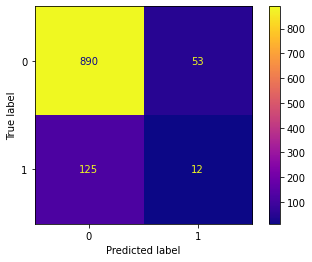

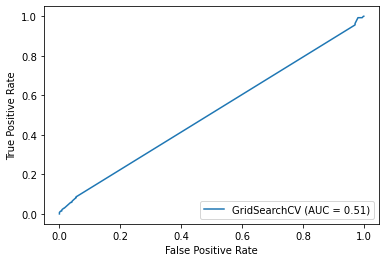

In [52]:
pipe_dt = pipe_maker_bnb(BernoulliNB)
grid_params_dt = [{'clf__alpha': [.1,.2,.3],
                  'clf__binarize': [1.5,2,2.5]}]
gs_dt = gridsearch_maker(pipe_dt, grid_params_dt)
best_acc(gs_dt)

Train:               precision    recall  f1-score   support

           0       0.53      0.89      0.67      2851
           1       0.67      0.22      0.34      2851

    accuracy                           0.56      5702
   macro avg       0.60      0.56      0.50      5702
weighted avg       0.60      0.56      0.50      5702

Test:               precision    recall  f1-score   support

           0       0.89      0.88      0.88       943
           1       0.21      0.23      0.22       137

    accuracy                           0.79      1080
   macro avg       0.55      0.55      0.55      1080
weighted avg       0.80      0.79      0.80      1080



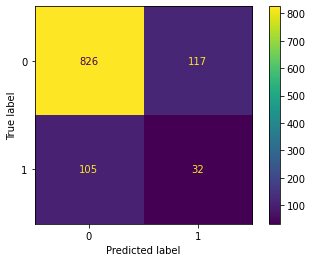

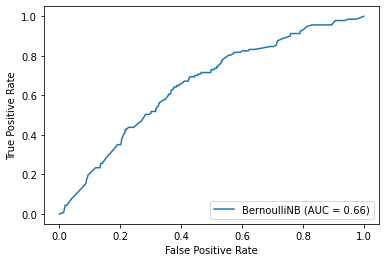

In [47]:
# Instantiate, fit, and run model
bnb = BernoulliNB()
bnb.fit(X_train_scaled, y_train)
y_hat_train = bnb.predict(X_train_smote)
y_hat_test = bnb.predict(X_test_scaled)
print(f'Train: {classification_report(y_train_smote, y_hat_train)}')
print(f'Test: {classification_report(y_test, y_hat_test)}')

# Plot confusion matrix and ROC AUC
plot_confusion_matrix(bnb, X_test_scaled, y_test)
plot_roc_curve(bnb, X_test_scaled, y_test);

### Model 5: Combined Ensemble Model (Logistic Regression, Random Forest, XGBoost, Naive Bayes)

Train:               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2851
           1       1.00      1.00      1.00      2851

    accuracy                           1.00      5702
   macro avg       1.00      1.00      1.00      5702
weighted avg       1.00      1.00      1.00      5702

Test:               precision    recall  f1-score   support

           0       0.88      0.90      0.89       943
           1       0.20      0.18      0.19       137

    accuracy                           0.81      1080
   macro avg       0.54      0.54      0.54      1080
weighted avg       0.80      0.81      0.80      1080



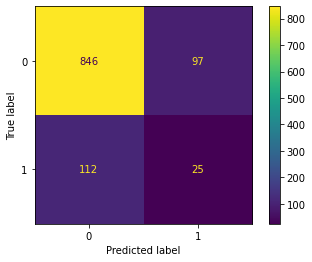

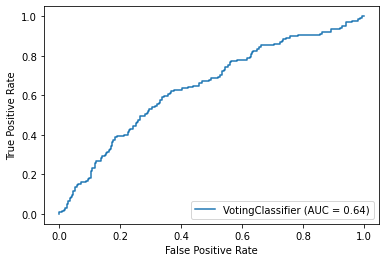

In [100]:
# Combined hypertuned prior models for ultimate ensemble
clf1 = LogisticRegression(max_iter=10000, dual=True, penalty='l2', solver='liblinear', random_state=22)
clf2 = RandomForestClassifier(class_weight='balanced', criterion='gini', max_depth=50, random_state=22)
clf3 = XGBClassifier(booster='gbtree', eta=0.25, max_depth=8, random_state=22)
clf4 = BernoulliNB(alpha=0.1, binarize=2.5)

w_avg = VotingClassifier(estimators=[
    ('lr', clf1),
    ('rf', clf2),
    ('xgb', clf3),
    ('bnb', clf4)],
     voting='soft')
w_avg.fit(X_train_smote, y_train_smote) 
y_hat_train = w_avg.predict(X_train_smote)
y_hat_test = w_avg.predict(X_test_scaled)
print(f'Train: {classification_report(y_train_smote, y_hat_train)}')
print(f'Test: {classification_report(y_test, y_hat_test)}')

# Plot confusion matrix and ROC AUC
plot_confusion_matrix(w_avg, X_test_scaled, y_test)
plot_roc_curve(w_avg, X_test_scaled, y_test);

### Comparing Models

In [92]:
LogReg = ['Logistic Regression', 0.63, 0.65, 0.29]
RanFor = ['Random Forest', 0.82, 0.62, 0.2]
XGBoost = ['XGBoost', 0.83, 0.61, 0.18]
Naive_Bayes = ['Naive Bayes', 0.84, 0.51, 0.22]
Combined = ['Combined Models', 0.81, 0.64, 0.19]
all_models = pd.DataFrame(list([LogReg,RanFor,XGBoost,Naive_Bayes,Combined]), 
                          columns=['Model','Accuracy','AUC', 'f1 score']).sort_values('Accuracy', ascending=False)
all_models

,Model,Accuracy,AUC,f1 score
3,Naive Bayes,0.84,0.51,0.22
2,XGBoost,0.83,0.61,0.18
1,Random Forest,0.82,0.62,0.20
4,Combined Models,0.81,0.64,0.19
0,Logistic Regression,0.63,0.65,0.29
